# Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from NCA.NCA import *
import NCA.utils as utils
from IPython.display import Image, HTML, clear_output
import logging
import os
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# Initial Setup 

In [2]:
DEVICE = "cuda:0" #<-- Device to use, CUA recommended 
HEIGHT = 30
WIDTH = 30
CHANNELS = 16 #<--- NCA feature channels
BATCH_SIZE = 12  
PADDING = 5
GENE_COUNT = 8 #<-- Number of gene channels to use for "private" information 
POOL_SIZE = 2666 #<--- NCA training pool size, lower values train faster but are less stable
TRAINING_ITERS = 14000  #<-- Number of trainign iterations 
PRIMITIVES = ["../Images/square.png", "../Images/circle.png", "../Images/triangle.png"]
BODY_PARTS = ["../Images/Torso.png", "../Images/Head.png", "../Images/Tail.png", "../Images/leg1.png", "../Images/leg2.png", "../Images/leg3.png", "../Images/leg4.png"]

# Loading and Setting up Images

In [3]:
paths = PRIMITIVES #<-- change between PRIMITIVES or BODY_PARTS 
images = []
images_to_display = []
for path in paths:
    image, image_to_display = utils.get_image(path, HEIGHT, WIDTH, padding=PADDING)
    images.append(image)
    images_to_display.append(image_to_display)
    
genes = [[0], [2], [1]] # <-- Gene one hot encoding, indicates which bits if the gene sequence for each encoded "image" should be 1, [0] = 001, [0,1] = 011, [2] = 100 etc. for 3 bits genes. One, one-hot encoding per image, this rule applies for any gene size 

HEIGHT = HEIGHT + 2*PADDING
WIDTH = WIDTH + 2*PADDING
assert len(paths) == len(genes), 'Genes and images should have the same length '

# Displaying Images and Making Training Pools

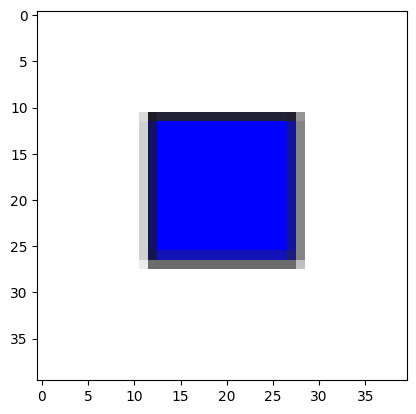

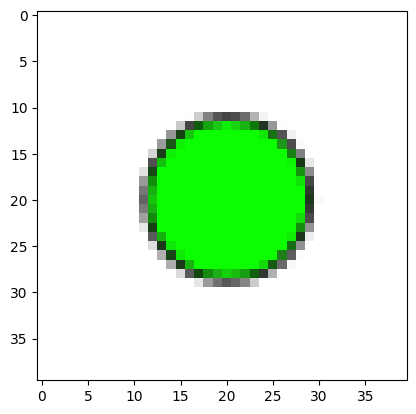

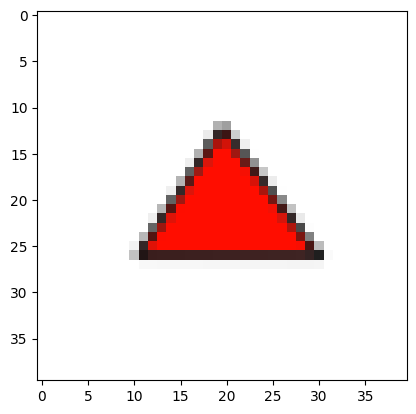

In [4]:
for i,image in enumerate(images_to_display):
    plt.figure(3+i)
    plt.imshow(image)
pools = []
for gene in genes:
    pools.append(utils.make_gene_pool(gene, pool_size=POOL_SIZE,height=HEIGHT, width=WIDTH, channels=CHANNELS, gene_size=8))
seeds = []
for pool in pools:
    seeds.append(pool[0].clone())



# Creating Batch Partitions for Every Image 

In [ ]:
partitions = len(paths)
if partitions == 1:
    part = [BATCH_SIZE]
div = BATCH_SIZE//partitions
rem = BATCH_SIZE % partitions
part = [div + 1 if i < rem else div for i in range(partitions)]
print(part)

# Filters for Loss Function

In [ ]:
sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]], dtype=torch.float32, device="cuda:0")
lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]], dtype=torch.float32, device="cuda:0")
filters = torch.stack([sobel_x, sobel_x.T, lap])
folder = "Gene"


# Dirr Setup for Saving Models and Experimental Data 

In [ ]:
path = "Trained_models/" + folder
if not os.path.exists(path):
    os.makedirs(path)
    print(f"Path: {path} created")
else: 
    print(f"Path: {path} already exists, all OK!")
    
path = "Saved_Data/" + folder
if not os.path.exists(path):
    os.makedirs(path)
    print(f"Path: {path} created")
else: 
    print(f"Path: {path} already exists, all OK!")

# Setting Up NCA and Batched Target Image 

In [ ]:
bases = [images[i].tile(part[i],1,1,1) for i in range(len(part))]
base = torch.cat(bases, dim =0 )
loss_log = []
nca = GeneCA(CHANNELS,64, gene_size=GENE_COUNT)
nca = nca.to(DEVICE)
optim = torch.optim.AdamW(nca.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5000, gamma=0.3)
name = folder + "/" +type(nca).__name__ + "_gene_size_" +str(GENE_COUNT)

# Training

In [ ]:
for i in range(TRAINING_ITERS + 1):
    loss = 0
    with torch.no_grad():
        idxs, x = utils.get_gene_pool(pools, part, seeds)

    for _ in range( random.randrange(32,92)):
        x = nca(x)
    loss = (base - x[:, :4, :, :]).pow(2).sum() + 0.1 *(perchannel_conv(base, filters) - perchannel_conv(x[:, :4, :, :], filters) ).pow(2).sum() 
    with torch.no_grad():
        loss.backward()
        for p in nca.parameters():
            p.grad /= (p.grad.norm() + 1e-8)
        optim.step()
        
        x = x.detach()
        optim.zero_grad()
    
    loss_log.append(loss.log().item())
    with torch.no_grad():   
        pools = utils.udate_gene_pool(pools, x.clone().detach(), idxs, part)
    scheduler.step()
    
    if i % 100 == 0:
        print(f"Training itter {i}, loss = {loss.item()}")
        plt.clf()
        clear_output()
        plt.figure(1,figsize=(10, 4))
        plt.title('Loss history)')
        print(name)
        plt.plot(loss_log, '.', alpha=0.5, color = "b")
        utils.show_batch(x[2:10])
        plt.show(block=False)
        plt.pause(0.01)
    if i % 100 == 0:
        torch.save(nca.state_dict(), "Trained_models/" + name + ".pth")
        print("Trained_models/" + name + ".pth")

np_logg = np.asarray(loss_log)
np.save("Saved_Data/" + name + "_data", np_logg)
